In [25]:
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from sklearn.metrics import f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
import os
import cv2
import random

In [26]:
# Function to preprocess data
def preprocess_data(data, target_shape):
    resized_data = [resize(image, target_shape, mode='reflect') for image in data]
    data_array = np.array(resized_data, dtype=np.float32)
    data_array /= 255.0
    return data_array


In [27]:
# Data preparation
data_folder = 'data'
cancer_folder = os.path.join(data_folder, 'cancer')
non_cancer_folder = os.path.join(data_folder, 'non-cancer')

if not os.path.exists(data_folder):
    os.makedirs(data_folder)

if not os.path.exists(cancer_folder):
    os.makedirs(cancer_folder)

if not os.path.exists(non_cancer_folder):
    os.makedirs(non_cancer_folder)

images = []
labels = []


In [28]:
for folder in [cancer_folder, non_cancer_folder]:
    for filename in os.listdir(folder):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(folder, filename)
            image = cv2.imread(image_path)
            images.append(image)
            labels.append(1 if folder == cancer_folder else 0)


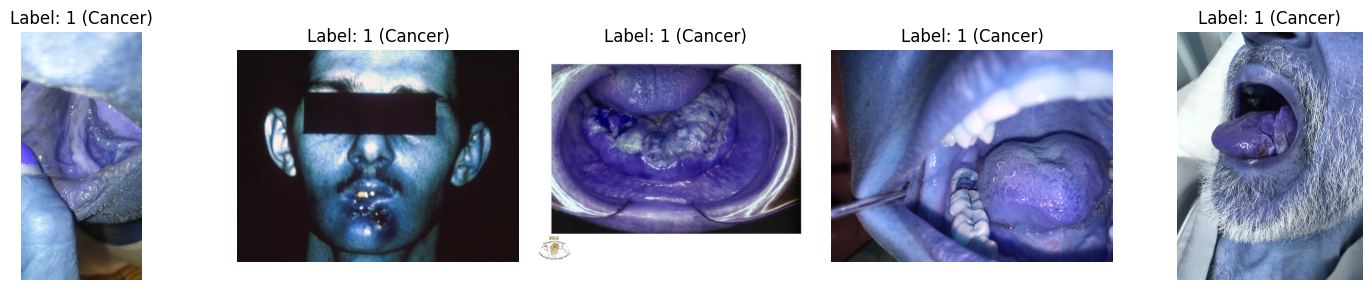

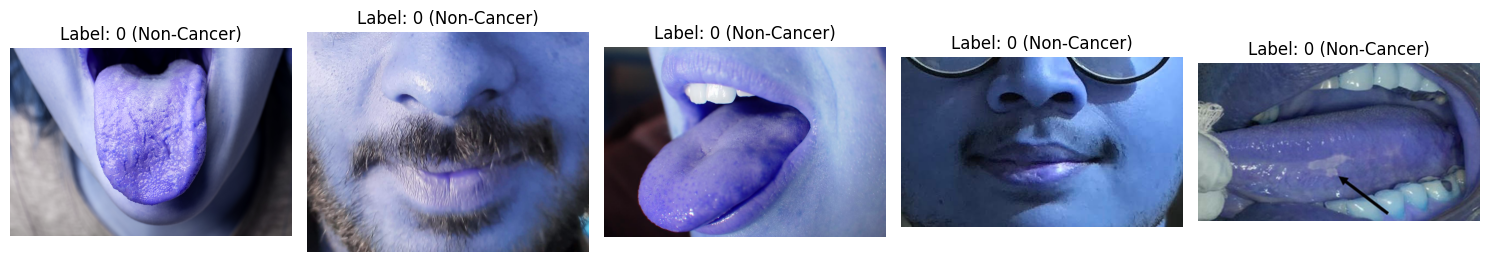

In [29]:
# Display images
num_samples = 5
cancer_images = [image for image, label in zip(images, labels) if label == 1][:num_samples]

fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
for i in range(num_samples):
    axes[i].imshow(cancer_images[i])
    axes[i].set_title("Label: 1 (Cancer)")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

non_cancer_images = [image for image, label in zip(images, labels) if label == 0][:num_samples]
fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
for i in range(num_samples):
    axes[i].imshow(non_cancer_images[i])
    axes[i].set_title("Label: 0 (Non-Cancer)")
    axes[i].axis('off')
plt.tight_layout()
plt.show()


In [30]:
# Convert to NumPy arrays
images_array = np.array(images)
labels_array = np.array(labels)


<ipython-input-30-300909b8c64a>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images_array = np.array(images)


In [31]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images_array, labels_array, test_size=0.2, random_state=42)

# Data augmentation
datagen = ImageDataGenerator(
    zoom_range=0.2,
    shear_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    rescale=1./255,
    horizontal_flip=True
)

augmented_images = []
augmented_labels = []

for image, label in zip(X_train, y_train):
    image = image.reshape((1,) + image.shape)
    label = np.array([label])
    augmented_data = datagen.flow(image, label, batch_size=1)
    for augmented_image, augmented_label in augmented_data:
        augmented_images.append(augmented_image[0])
        augmented_labels.append(augmented_label[0])
        break

# Convert augmented data to NumPy arrays
augmented_images_array = np.array(augmented_images)
augmented_labels_array = np.array(augmented_labels)


<ipython-input-31-96742facf8bd>:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  augmented_images_array = np.array(augmented_images)


In [32]:
# Combine original and augmented data
X = np.concatenate((X_train, X_test, augmented_images_array), axis=0)
y = np.concatenate((y_train, y_test, augmented_labels_array), axis=0)


In [33]:
# Split data into train, validation, and test sets
validation_size = 0.15
test_size = 0.15

X_train_data, X_temp, y_train_data, y_temp = train_test_split(X, y, test_size=(validation_size + test_size), random_state=42)
X_val_data, X_test_data, y_val_data, y_test_data = train_test_split(X_temp, y_temp, test_size=(test_size / (validation_size + test_size)), random_state=42)


In [34]:
# Print the sizes of the datasets
print("Train set size:", len(X_train_data))
print("Validation set size:", len(X_val_data))
print("Test set size:", len(X_test_data))


Train set size: 147
Validation set size: 31
Test set size: 32


In [35]:
# Preprocess data
target_shape = (256, 256, 3)
X_train_data_preprocessed = preprocess_data(X_train_data, target_shape)
X_val_data_preprocessed = preprocess_data(X_val_data, target_shape)
X_test_data_preprocessed = preprocess_data(X_test_data, target_shape)


In [36]:
# Convert data to TensorFlow tensors
X_train_data_tensor = tf.convert_to_tensor(X_train_data_preprocessed)
y_train_data_tensor = tf.convert_to_tensor(y_train_data)
X_val_data_tensor = tf.convert_to_tensor(X_val_data_preprocessed)
y_val_data_tensor = tf.convert_to_tensor(y_val_data)
X_test_data_tensor = tf.convert_to_tensor(X_test_data_preprocessed)
y_test_data_tensor = tf.convert_to_tensor(y_test_data)


In [37]:
# Load MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Build model
model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

# Compile model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 128)               163968    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                      

In [38]:
# Callbacks
mc = ModelCheckpoint(filepath="oc_cnn_final_model.hdf5", verbose=0, save_best_only=True)

# Training with data augmentation
history = model.fit(datagen.flow(X_train_data_preprocessed, y_train_data, batch_size=32),
                    epochs=50,
                    validation_data=(X_val_data_preprocessed, y_val_data),
                    callbacks=[mc])

Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 0.8022 - accuracy: 0.5238

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 7s 707ms/step - loss: 0.8022 - accuracy: 0.5238 - val_loss: 0.7691 - val_accuracy: 0.1935
Epoch 2/50
5/5 [==============================] - 3s 712ms/step - loss: 0.7845 - accuracy: 0.5238 - val_loss: 0.8051 - val_accuracy: 0.1935
Epoch 3/50
5/5 [==============================] - 2s 489ms/step - loss: 0.7930 - accuracy: 0.5102 - val_loss: 0.8033 - val_accuracy: 0.1935
Epoch 4/50
5/5 [==============================] - 3s 611ms/step - loss: 0.8367 - accuracy: 0.4898 - val_loss: 0.7424 - val_accuracy: 0.1935
Epoch 5/50
5/5 [==============================] - 4s 803ms/step - loss: 0.8812 - accuracy: 0.4354 - val_loss: 0.7016 - val_accuracy: 0.1935
Epoch 6/50
5/5 [==============================] - 3s 596ms/step - loss: 0.8363 - accuracy: 0.4558 - val_loss: 0.6946 - val_accuracy: 0.3226
Epoch 7/50
5/5 [==============================] - 2s 477ms/step - loss: 0.7866 - accuracy: 0.4354 - val_loss: 0.7142 - val_accuracy: 0.1935
Epoch 8/50
5/5 [===============

In [39]:
# Fine-tune by unfreezing some layers
for layer in model.layers[:100]:
    layer.trainable = True

# Recompile model after unfreezing
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Continue training with unfrozen layers
history_fine_tune = model.fit(datagen.flow(X_train_data_preprocessed, y_train_data, batch_size=32),
                              epochs=50,
                              validation_data=(X_val_data_preprocessed, y_val_data),
                              callbacks=[mc])


Epoch 1/50
5/5 [==============================] - 26s 571ms/step - loss: 0.7362 - accuracy: 0.5170 - val_loss: 0.6382 - val_accuracy: 0.8065
Epoch 2/50
5/5 [==============================] - 4s 742ms/step - loss: 0.7286 - accuracy: 0.5442 - val_loss: 0.6614 - val_accuracy: 0.8065
Epoch 3/50
5/5 [==============================] - 3s 509ms/step - loss: 0.7421 - accuracy: 0.5374 - val_loss: 0.6804 - val_accuracy: 0.8065
Epoch 4/50
5/5 [==============================] - 3s 500ms/step - loss: 0.7184 - accuracy: 0.5510 - val_loss: 0.6872 - val_accuracy: 0.7742
Epoch 5/50
5/5 [==============================] - 3s 504ms/step - loss: 0.6657 - accuracy: 0.6054 - val_loss: 0.7047 - val_accuracy: 0.1935
Epoch 6/50
5/5 [==============================] - 4s 737ms/step - loss: 0.7033 - accuracy: 0.5714 - val_loss: 0.7182 - val_accuracy: 0.1935
Epoch 7/50
5/5 [==============================] - 3s 512ms/step - loss: 0.6848 - accuracy: 0.5986 - val_loss: 0.7445 - val_accuracy: 0.1935
Epoch 8/50
5/5 [===

In [40]:
# Load the best-fit model
model = load_model("oc_cnn_final_model.hdf5")

In [41]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test_data_tensor, y_test_data_tensor, verbose=0)
print("Test accuracy:", test_accuracy)

Test accuracy: 0.53125


In [42]:
# Make predictions on the test data
predictions = model.predict(X_test_data_tensor)
binary_predictions = np.round(predictions)


1/1 [==============================] - 1s 762ms/step


In [43]:
# Calculate F1 score
f1 = f1_score(y_test_data_tensor, binary_predictions)
print("F1 Score:", f1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_data_tensor, binary_predictions)
print("Confusion Matrix:")
print(conf_matrix)


F1 Score: 0.6938775510204082
Confusion Matrix:
[[ 0 15]
 [ 0 17]]


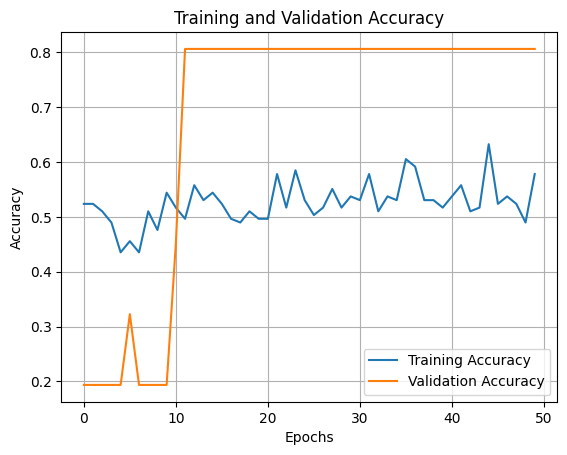

In [44]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

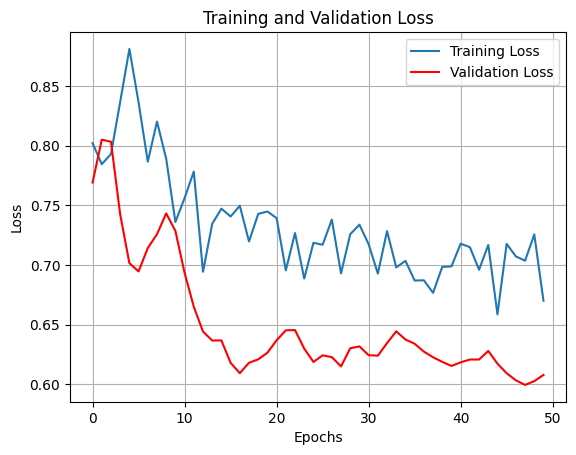

In [45]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()